# 03 - Time Series Forecasting Using Multilayer Perceptron (MLP)



## Notebook Description
This tutorial will showcase the usage of multilayer perceptron (MLP) in time series forecasting. The deep learning framework used here is PyTorch. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Prepare dataset to be feed into MLP model
2. Build and apply MLP model to perform forecasting
3. Compare and contrast performance of MLP model

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics](#analytics)
4. [Model Development](#model-dev)
5. [Evaluation](#evaluation)
6. [Exercise](#exercise)
7. [Reference](#reference)
8. [Bonus](#bonus)

## <a name="configuration">Notebook Configurations</a>
Following are the modules that will be used for this tutorial. This notebook will heavily use `torch` as they provide great APIs when for building deep learning models. You can find out more about them [here](https://pytorch.org/).

In [14]:
# Importing libraries
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from sklearn.metrics import mean_squared_error

# seed configuration
np.random.seed(38)
torch.manual_seed(38)

## <a name="dataset">Dataset</a>
We would be using the a time series data containing monthly shampoo sales for this exercise. It is a famous and commonly used dataset for time series forecasting practice. We will split the data into training and test dataset.

In [15]:
# path specification
#dataset_dir_path = Path().resolve().parent.parent/'datasets'
#data_dir_path = dataset_dir_path/'others'
#training_file_name = 'shampoo-sales.csv' 

# import dataset
df_shampoo = pd.read_csv('Data/others/shampoo-sales.csv')

## <a name="analytics">Basic Analytics</a>
Let's do some basic analytics and see what nugget can we find out of the training dataset! Let first find out the number of rows and columns of the training dataset.

**Note: Since we are not supposed to know any information about the test dataset, we will not perform any analytics on it.**

In [16]:
# inspect first 15 rows of data
df_shampoo.head(15)

,month,sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3
5,1-06,168.5
6,1-07,231.8
7,1-08,224.5
8,1-09,192.8
9,1-10,122.9


We can see that there are two columns, month and sales. Let's also inspect the data type for each column.

In [17]:
# compute dtype
for column in df_shampoo.columns:
    print(f"The data type for '{column}' column is: {df_shampoo[column].dtype}")

The data type for 'month' column is: object
The data type for 'sales' column is: float64


Now, we will compute the descriptive statistics.

In [18]:
# compute descriptive statistics
df_shampoo.describe()

,sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


The descriptive statistics computed are the mean, standard deviation, minimum and maximum values. We see that the maximum value is 682.00 and minimum value is 119.30, and the standard deviation is 148.94. This shows that the sales volume varies by a large spread. Next, we will plot a time plot for the data.

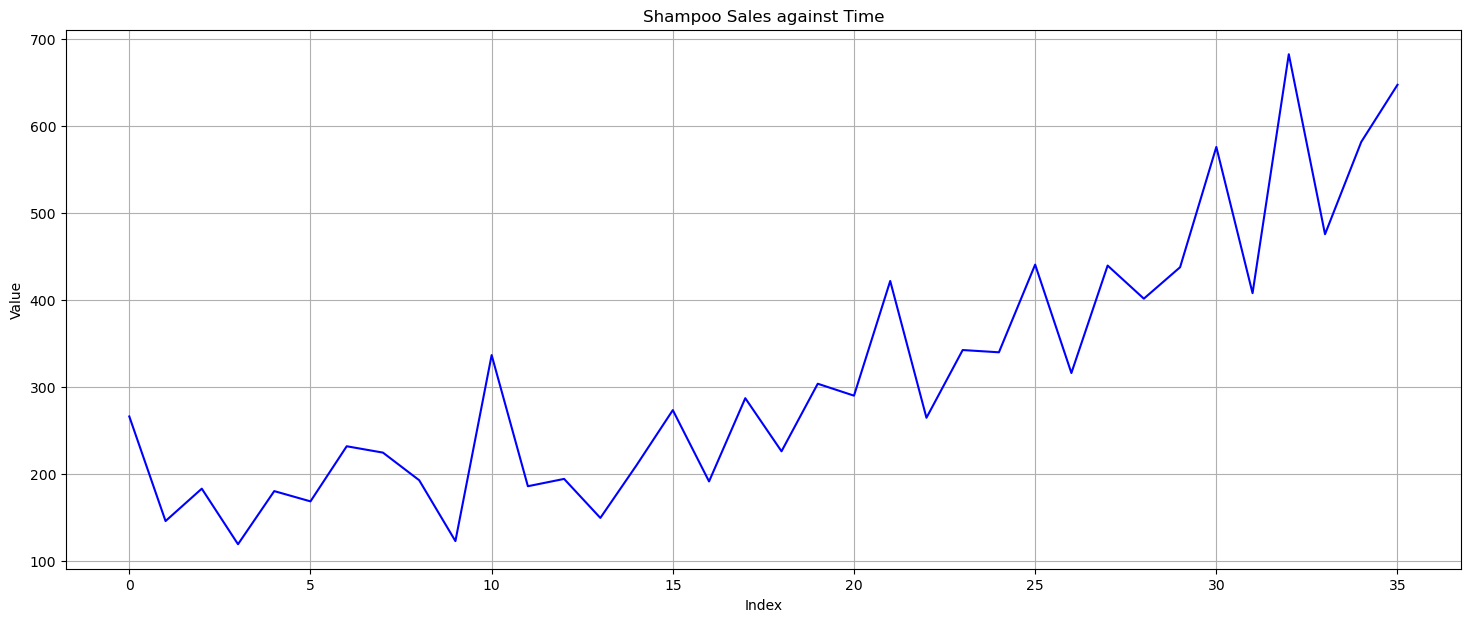

In [19]:
# plot time plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Shampoo Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_shampoo['sales'],
    color='blue', label='Data');

Now that we get to feel the ebb and flow of the data. Let's split the dataset into training and test set.

In [20]:
# split dataset
df_train, df_test = train_test_split(df_shampoo, train_size=0.7, shuffle=False)

# display training dataset length
print(f"The length of training dataset is: {len(df_train)}")

# display test dataset length
print(f"The length of test dataset is: {len(df_test)}")

The length of training dataset is: 25
The length of test dataset is: 11


Let's see what are the portion of dataset which is splitted as training dataset and test dataset.

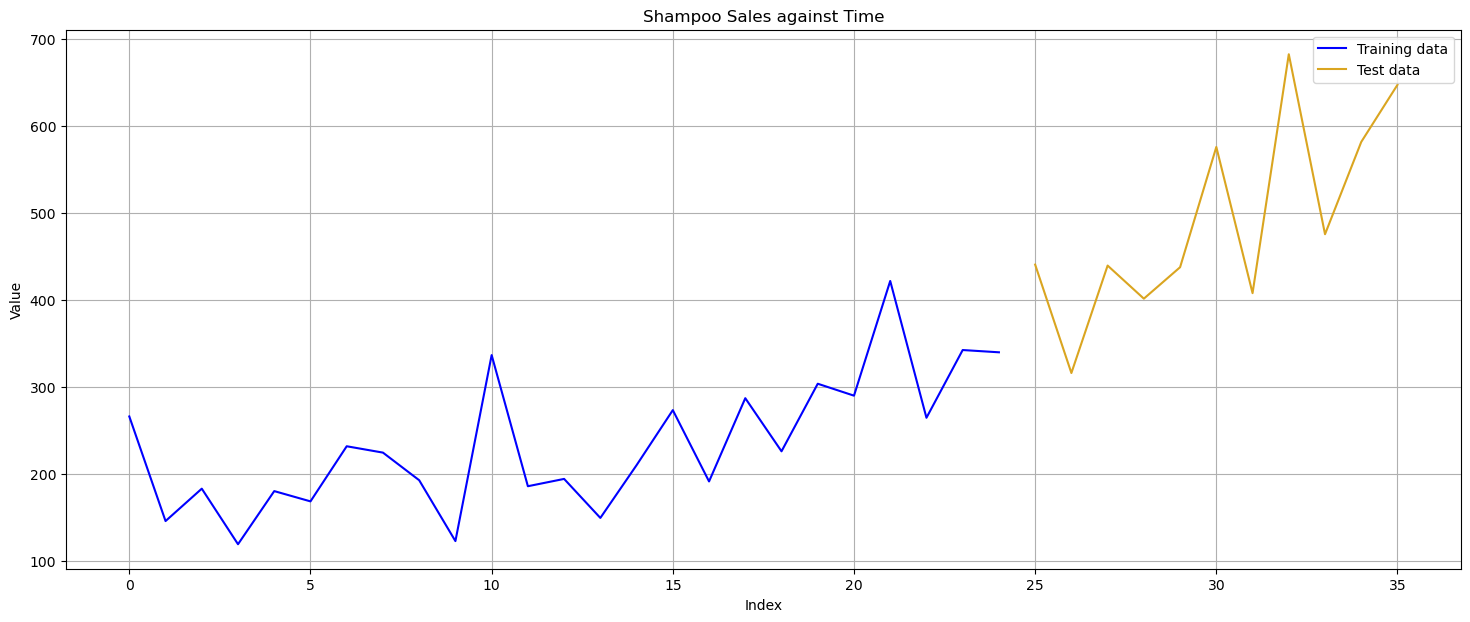

In [21]:
# plot time plot for training and test dataset 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Shampoo Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_train['sales'],
    color='blue', label='Training data');
ax.plot(
    df_test['sales'],
    color='goldenrod', label='Test data')
ax.legend();

Feature scalinng also help in shortening model training time. Let's do that too.

In [22]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train['sales'].values.reshape(-1,1))
test_scaled = scaler.transform(df_test['sales'].values.reshape(-1,1))

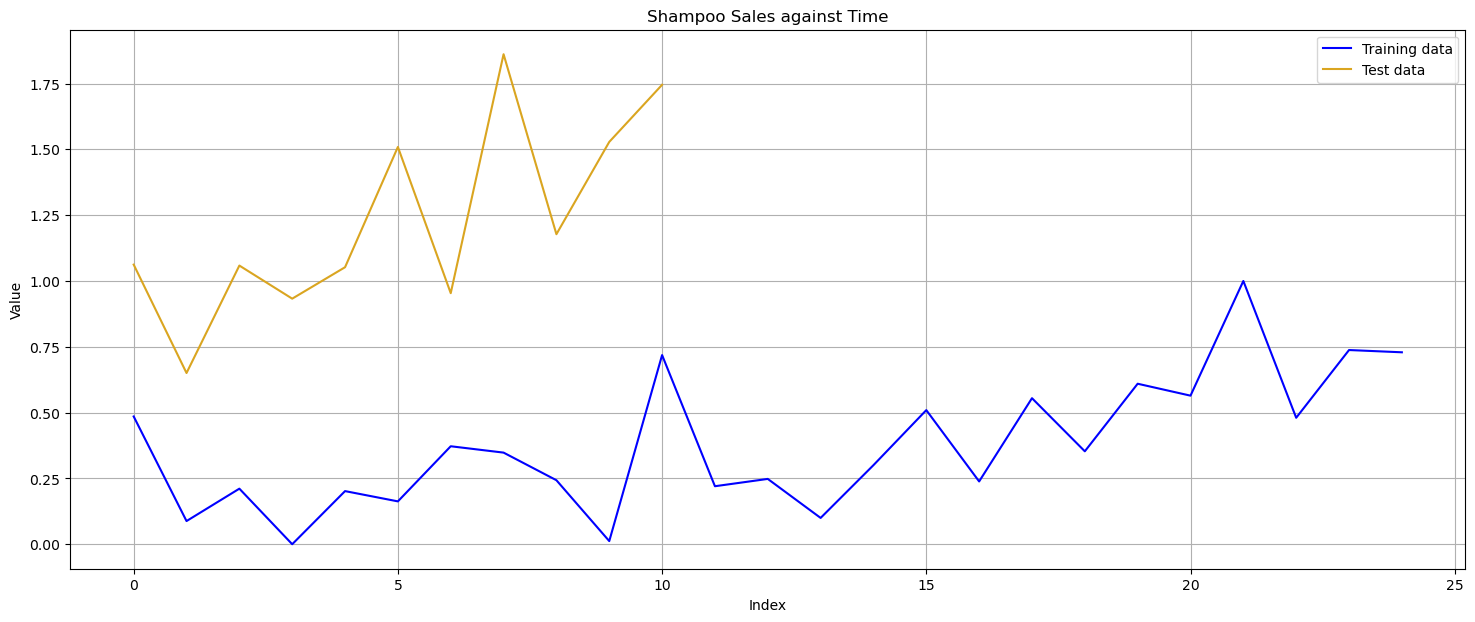

In [23]:

# plot time plot for training and test dataset 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Shampoo Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    train_scaled,
    color='blue', label='Training data');
ax.plot(
    test_scaled,
    color='goldenrod', label='Test data')
ax.legend();

## <a name="model-dev">Model Development</a>
The `torch` library provides a number of API to easily construct a MLP model for the tasks at hand. But first, we will need to prepare the dataset into a format ingestible by the model first. We will first transform the time series data into feature of label, where the feature would be a sequence of *n* length of data and label would be lead-1 of the last data in the feature.

In [24]:
# write a helper function which slices through the features using the sequence_length parameter and index the labe at the time step
# function should return features in sequence and labels
def sequencing_data(data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be in np.ndarray.
    """
    x, y = [], []

    for i in range(data.shape[0] - sequence_length):

        # copy the sequences of data starting at this index
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return x, y

# calling the helper function and store them in variables
#Taille de la fenetre : Prendre 3 valeurs pour predire la 4 eme informations pour ne pas entrer dans le underfitting ou overfitting
X_sequence_train, y_sequence_train = sequencing_data(train_scaled, 3)
X_sequence_test, y_sequence_test = sequencing_data(test_scaled, 3)

# sanity check 
print("Total samples for X train: " + str(len(X_sequence_train)))
print("Total samples for y train: " + str(len(y_sequence_train)))
print("Total samples for X test: " + str(len(X_sequence_test)))
print("Total samples for y test: " + str(len(y_sequence_test)))

Total samples for X train: 22
Total samples for y train: 22
Total samples for X test: 8
Total samples for y test: 8


Let's write a custom `Dataset` class to transfrom the data into tuples of `torch.Tensor`. This is necessary if we want to load the data in batches using `DataLoader`.

In [25]:
class ShampooDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """ 
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

We will write the codes to convert data into `Dataset` object and then into `DataLoader` object. We will be using a batch size of 4 for this `DataLoader` object.

In [26]:
# declare batch size
batch_size = 4

# convert into Dataset using customized class
train_Dataset = ShampooDataset(X_sequence_train, y_sequence_train)
test_Dataset = ShampooDataset(X_sequence_test, y_sequence_test)

# convert into DataLoader
train_loader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_Dataset, batch_size=batch_size, shuffle=False)

# declare a dict object
dataloaders = {'train': train_loader, 'test': test_loader} 

/var/folders/_8/n21p2rcd5sd4yqhw8z4mbdr40000gn/T/ipykernel_60398/4223190313.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  self.x = torch.FloatTensor(x)


It's about time to declare our MLP model architecture. The following code demonstrates how to build a simple MLP model.

In [27]:
class MLP(nn.Module):
    """MLP model with configurable input size and output size."""
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, 64)
        self.linear1 = nn.Linear(64, 16)
        self.output = nn.Linear(16, output_size)
    
    def forward(self, x):
        x = x.view(-1, 1, 3)
        out = F.relu(self.input(x))
        out = F.relu(self.linear1(out))
        out = self.output(out)
        return out

Before we can start our training, we also need to configure some hyperparameters. Let's do that.

In [28]:
# reproducibility
torch.manual_seed(38)

# setting hyperparameter
input_size = 3
output_size = 1
epochs = 100
learning_rate = 0.001

# instantiate the model
model = MLP(input_size, output_size)

# continue setting hyperparameter
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

We can perform our model training now. In `torch`, we need to manually write codes to implement model training.

In [29]:
# implement model training and validation loop
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, (X, y) in enumerate(dataloaders[phase]):
            with torch.set_grad_enabled(phase == 'train'):
                out = model(X)
                loss = criterion(out.squeeze(), y.squeeze())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)


We can plot the loss score to check how is the model performing when trained by epochs.

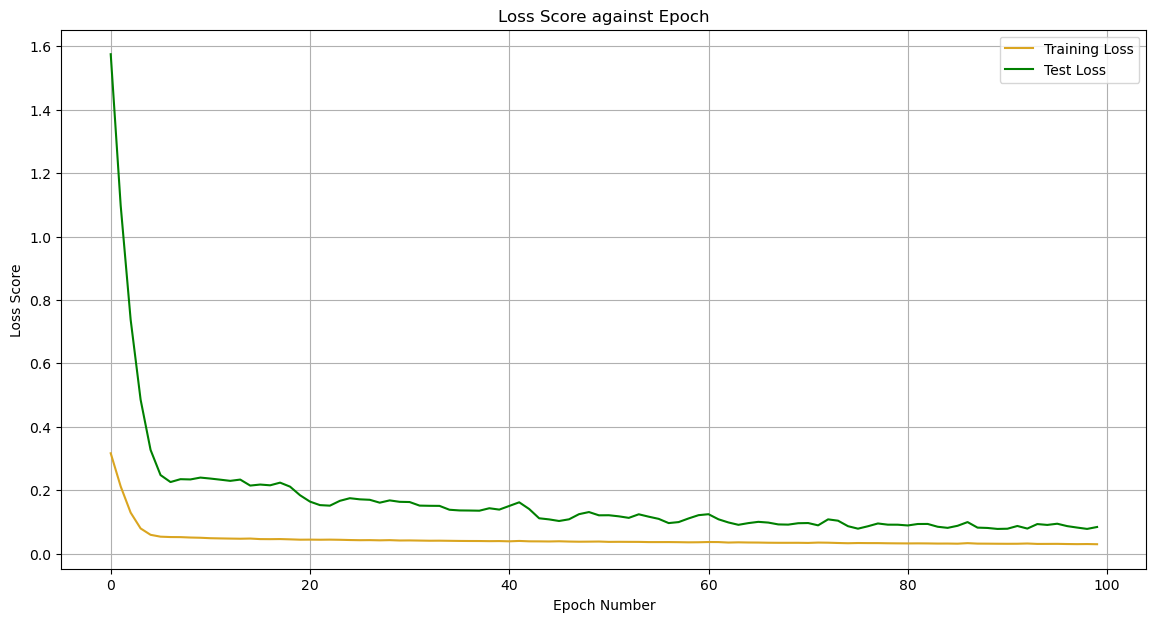

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")

ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();

## <a name="evaluation">Evaluation</a>
There are a few metrics that can be used to evaluate the performance of a regression model, which include:
* mean squared error (MSE)
* root mean squared error (RMSE)
* mean absolute error (MAE)

We will examine the performance of the model on test set using RMSE. 

In [31]:
model.eval()

predictions = []
count = 0

# model predictions
with torch.no_grad():
    for i, (X, y) in enumerate(DataLoader(test_Dataset, 1)):
        count += 1
        output = model(X)
        predictions.append(output.item())
        
# convert list into np array and inverse transform it into proper values before feature scaling
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(1,-1))

# remove beginning 3 rows of data since at least 3 data are needed to make a prediction
df_test = df_test.iloc[3:]
df_test['preds'] = predictions.squeeze()

# compute MSE
RMSE = mean_squared_error(df_test.preds, df_test.sales, squared=False)
print(f"The RMSE for the model is {RMSE}")

The RMSE for the model is 87.46341083021767


We can also print and visualize predictions made by the model for inspection purpose.

28    366.782294
29    425.677006
30    436.812790
31    470.707685
32    523.944089
33    483.943955
34    579.809390
35    539.221998
Name: preds, dtype: float64


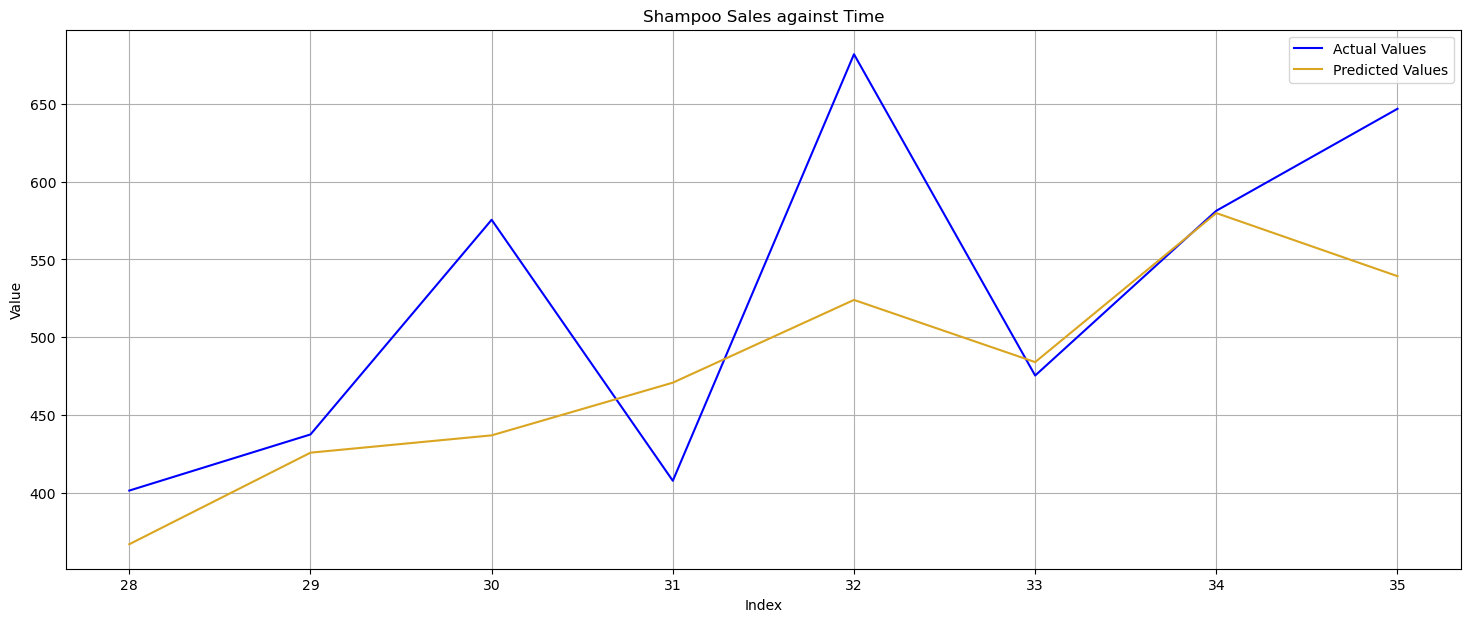

In [32]:
print(df_test['preds'])

# plot time plot for predictions and ground truth 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Shampoo Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_test['sales'],
    color='blue', label='Actual Values');
ax.plot(
    df_test['preds'],
    color='goldenrod', label='Predicted Values')
ax.legend();

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules which you need had already been imported at this point.

In [33]:
# import modules
### BEGIN SOLUTION
 
# import dataset
furniture = pd.read_csv("Data/others/furniture-sales.csv")

### END SOLUTION

### Dataset
**INSTRUCTIONS**: Please perform time series forecasting using MLP on furniture-sales.csv dataset. You can locate the file in the `datasets` folder.

In [34]:
# path specification
### BEGIN SOLUTION




### END SOLUTION

# import dataset
### BEGIN SOLUTION

### END SOLUTION

### Basic Analytics
**INSTRUCTIONS**: Perform some basic analytics on the dataset by following the guidelines that are provided in each cell.

In [35]:
# inspect first 15 rows of data
### BEGIN SOLUTION
furniture.head(15)
### END SOLUTION

,DATE,MRTSSM442USN
0,1992-01-01,3846
1,1992-02-01,3908
2,1992-03-01,4157
3,1992-04-01,4141
4,1992-05-01,4275
5,1992-06-01,4357
6,1992-07-01,4407
7,1992-08-01,4446
8,1992-09-01,4328
9,1992-10-01,4497


In [36]:
# compute dtype
### BEGIN SOLUTION
# compute dtype
for column in furniture.columns:
    print(f"The data type for '{column}' column is: {furniture[column].dtype}")

### END SOLUTION

The data type for 'DATE' column is: object
The data type for 'MRTSSM442USN' column is: int64


In [37]:
# rename column to 'Date' and 'Sales'
### BEGIN SOLUTION

furniture = furniture.rename(columns={'DATE': 'Dates','MRTSSM442USN':'Sales'})

### END SOLUTION

# compute descriptive statistics
### BEGIN SOLUTION

### END SOLUTION

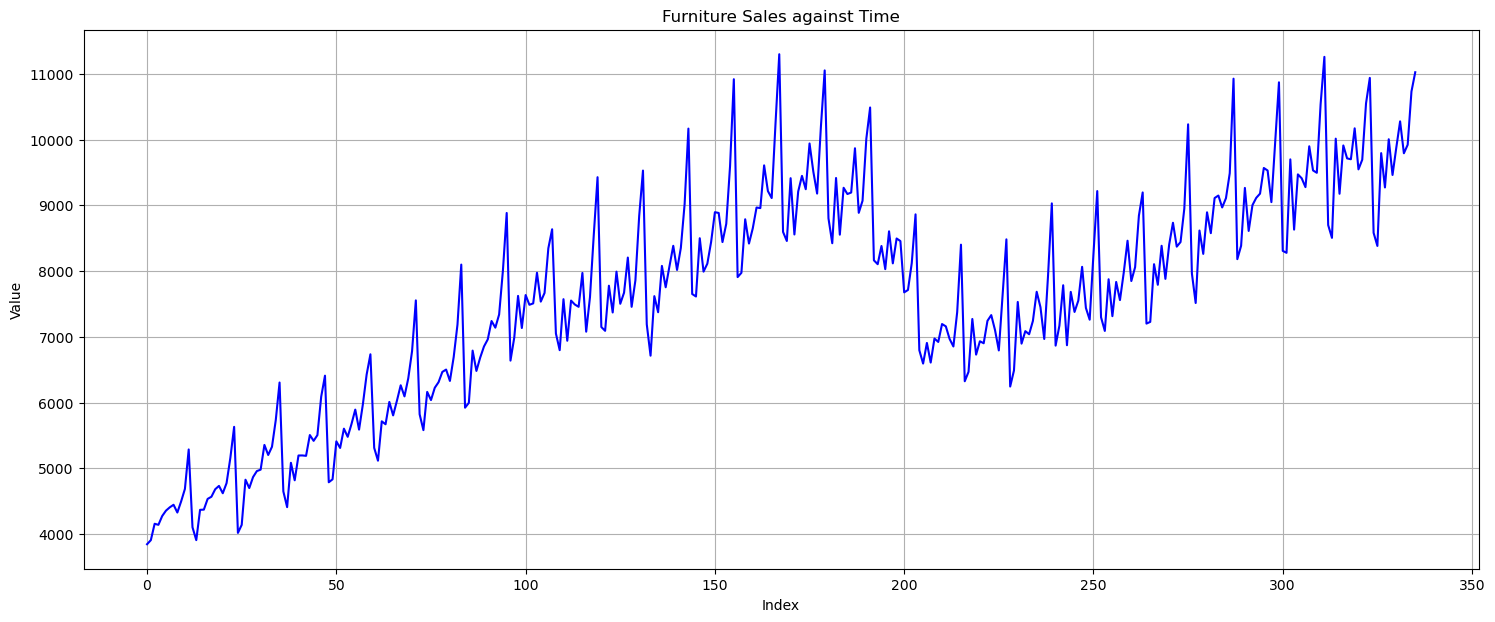

In [38]:
# plot time plot 
### BEGIN SOLUTION



# plot time plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Furniture Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    furniture['Sales'],
    color='blue', label='Data');




### END SOLUTION

In [39]:
# split dataset into 7:3 of train:test set from the whole dataset
### BEGIN SOLUTION
# split dataset
df_train, df_test = train_test_split(furniture, train_size=0.7, shuffle=False)
### END SOLUTION

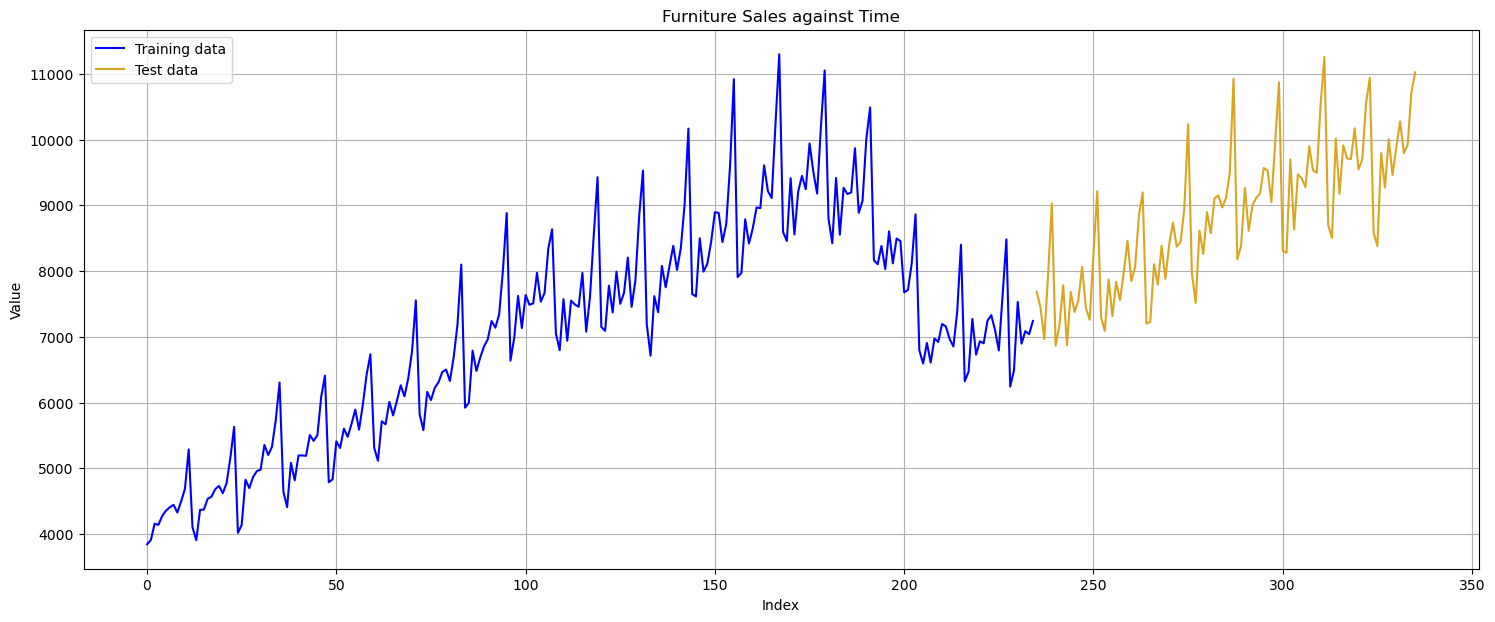

In [40]:
# plot time plot for training and test dataset 
### BEGIN SOLUTION




# plot time plot for training and test dataset 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Furniture Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_train['Sales'],
    color='blue', label='Training data');
ax.plot(
    df_test['Sales'],
    color='goldenrod', label='Test data')
ax.legend();





### END SOLUTION

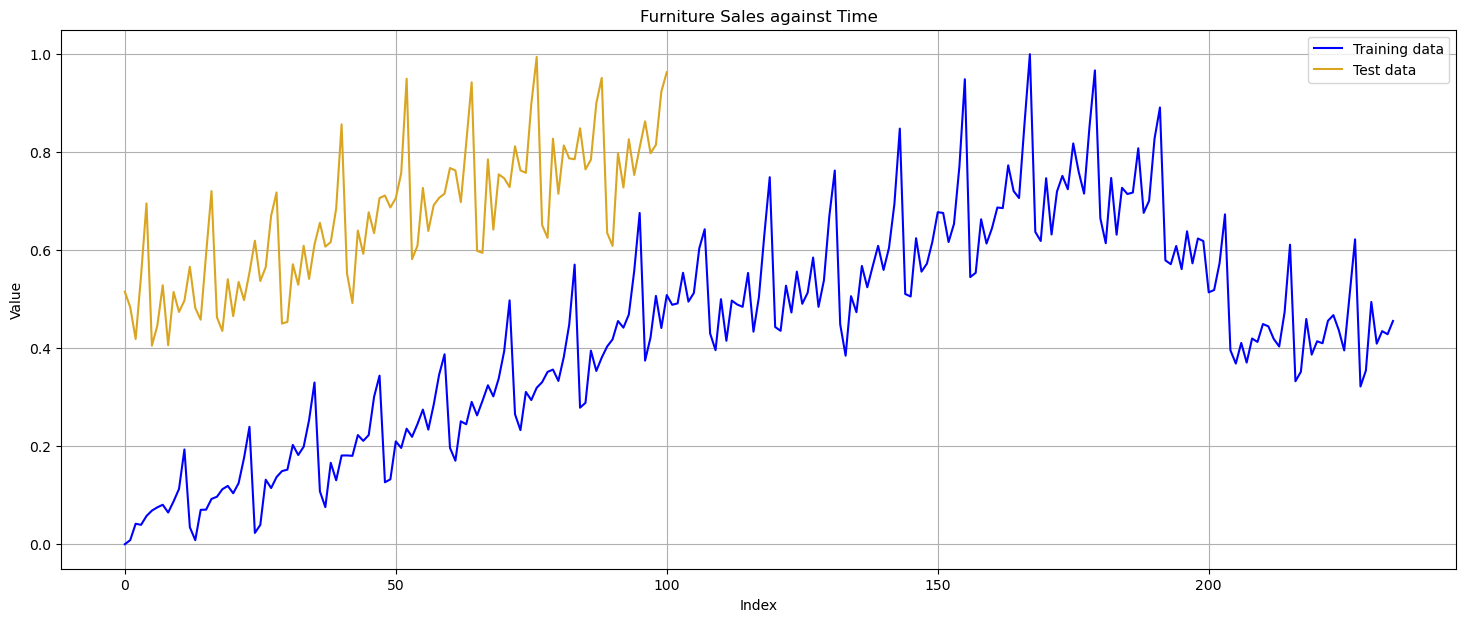

In [41]:
# feature scaling using min-max normalization
### BEGIN SOLUTION

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train['Sales'].values.reshape(-1,1))
test_scaled = scaler.transform(df_test['Sales'].values.reshape(-1,1))
# plot time plot for training and test dataset 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Furniture Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    train_scaled,
    color='blue', label='Training data');
ax.plot(
    test_scaled,
    color='goldenrod', label='Test data')
ax.legend();


### END SOLUTION

### Model Development
**INSTRUCTIONS**: Build and develop a MLP model using training dataset.

In [42]:
# write a helper function which slices through the features using the sequence_length parameter and index the labe at the time step
# function should return features in sequence and labels
def sequencing_data(data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be in np.ndarray.
    """
    x, y = [], []

    for i in range(data.shape[0] - sequence_length):

        # copy the sequences of data starting at this index
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return x, y

# calling the helper function and store them in variables
#Taille de la fenetre : Prendre 7 valeurs pour predire la 4 eme informations pour ne pas entrer dans le underfitting ou overfitting
X_sequence_train, y_sequence_train = sequencing_data(train_scaled, 7)
X_sequence_test, y_sequence_test = sequencing_data(test_scaled, 7)

# sanity check 
print("Total samples for X train: " + str(len(X_sequence_train)))
print("Total samples for y train: " + str(len(y_sequence_train)))
print("Total samples for X test: " + str(len(X_sequence_test)))
print("Total samples for y test: " + str(len(y_sequence_test)))






 

Total samples for X train: 228
Total samples for y train: 228
Total samples for X test: 94
Total samples for y test: 94


In [43]:
# write custom Dataset to transform list object into Dataset object
class FurnitureDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """ 
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [44]:
# declare batch size
batch_size = 4

# convert into Dataset using customized class
train_Dataset = ShampooDataset(X_sequence_train, y_sequence_train)
test_Dataset = ShampooDataset(X_sequence_test, y_sequence_test)

# convert into DataLoader
train_loader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_Dataset, batch_size=batch_size, shuffle=False)

# declare a dict object
dataloaders = {'train': train_loader, 'test': test_loader} 

In [45]:
class MLP(nn.Module):
    """MLP model with configurable input size and output size."""
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, 64)
        self.linear1 = nn.Linear(64, 16)
        self.output = nn.Linear(16, output_size)
    
    def forward(self, x):
        x = x.view(-1, 1, 7)
        out = F.relu(self.input(x))
        out = F.relu(self.linear1(out))
        out = self.output(out)
        return out

In [46]:
# reproducibility
torch.manual_seed(38)

# setting hyperparameter
input_size = 7
output_size = 1
epochs = 100
learning_rate = 0.002

# instantiate the model
model = MLP(input_size, output_size)

# continue setting hyperparameter
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


 

In [47]:
 


# implement model training and validation loop
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, (X, y) in enumerate(dataloaders[phase]):
            with torch.set_grad_enabled(phase == 'train'):
                out = model(X)
                loss = criterion(out.squeeze(), y.squeeze())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
        print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)







 

TRAIN Loss: 0.056934431605776284
TEST Loss: 0.02606165835118674
TRAIN Loss: 0.014354619893996994
TEST Loss: 0.014081883051016547
TRAIN Loss: 0.009012324689568854
TEST Loss: 0.012637726298751348
TRAIN Loss: 0.008055899055825808
TEST Loss: 0.009096549100619047
TRAIN Loss: 0.00859684991729936
TEST Loss: 0.009060916322422154
TRAIN Loss: 0.00840719906805214
TEST Loss: 0.010086848494656225
TRAIN Loss: 0.008683395255438722
TEST Loss: 0.012593962737616706
TRAIN Loss: 0.007860156089647493
TEST Loss: 0.008977955915628279
TRAIN Loss: 0.007580556641314935
TEST Loss: 0.009226224964801619
TRAIN Loss: 0.007676627662077775
TEST Loss: 0.00859779378082207
TRAIN Loss: 0.007553475010290481
TEST Loss: 0.012957722206223519
TRAIN Loss: 0.008034374646581056
TEST Loss: 0.009039175617409514
TRAIN Loss: 0.0073480669933926775
TEST Loss: 0.00880586277158495
TRAIN Loss: 0.007924011355498806
TEST Loss: 0.00937262821466999
TRAIN Loss: 0.0078950535369171
TEST Loss: 0.009478256170776612
TRAIN Loss: 0.007876016166400197

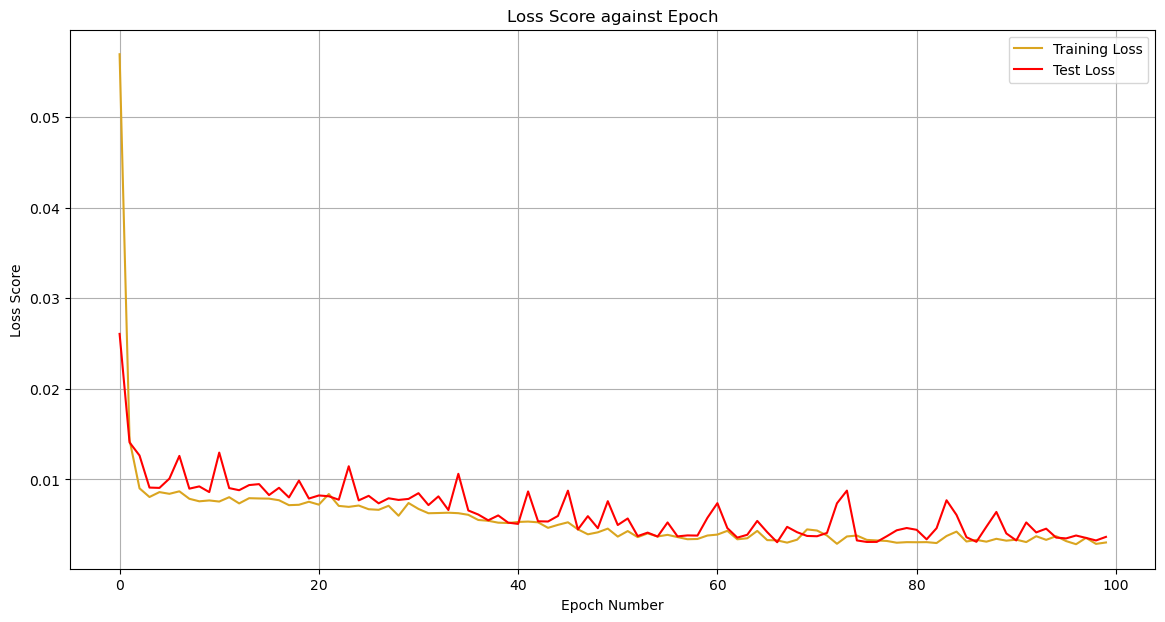

In [48]:
# plot loss scores
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")

ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='red', label='Test Loss')
ax.legend();

### Evaluation
**INSTRUCTIONS:** Follow the guidelines given in the cells to evaluate performance of model.

In [49]:
# model predictions

model.eval()
df_train, df_test = train_test_split(furniture, train_size=0.7, shuffle=False)
predictions = []
count = 0

# model predictions
with torch.no_grad():
    for i, (X, y) in enumerate(DataLoader(test_Dataset, 1)):
        count += 1
        output = model(X)
        predictions.append(output.item())
        
# convert list into np array and inverse transform it into proper values before feature scaling
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(1,-1))

# remove beginning 3 rows of data since at least 3 data are needed to make a prediction
df_test = df_test.iloc[7:]
df_test['preds'] = predictions.squeeze()

# compute MSE
RMSE = mean_squared_error(df_test.preds, df_test.Sales, squared=False)
print(f"The RMSE for the model is {RMSE}")

The RMSE for the model is 450.43605389653686


242     8059.337252
243     7542.084762
244     7432.909942
245     7856.709700
246     7568.542421
           ...     
331    10843.956432
332    10134.475546
333    10326.377295
334    10524.371403
335    11106.817417
Name: preds, Length: 94, dtype: float64


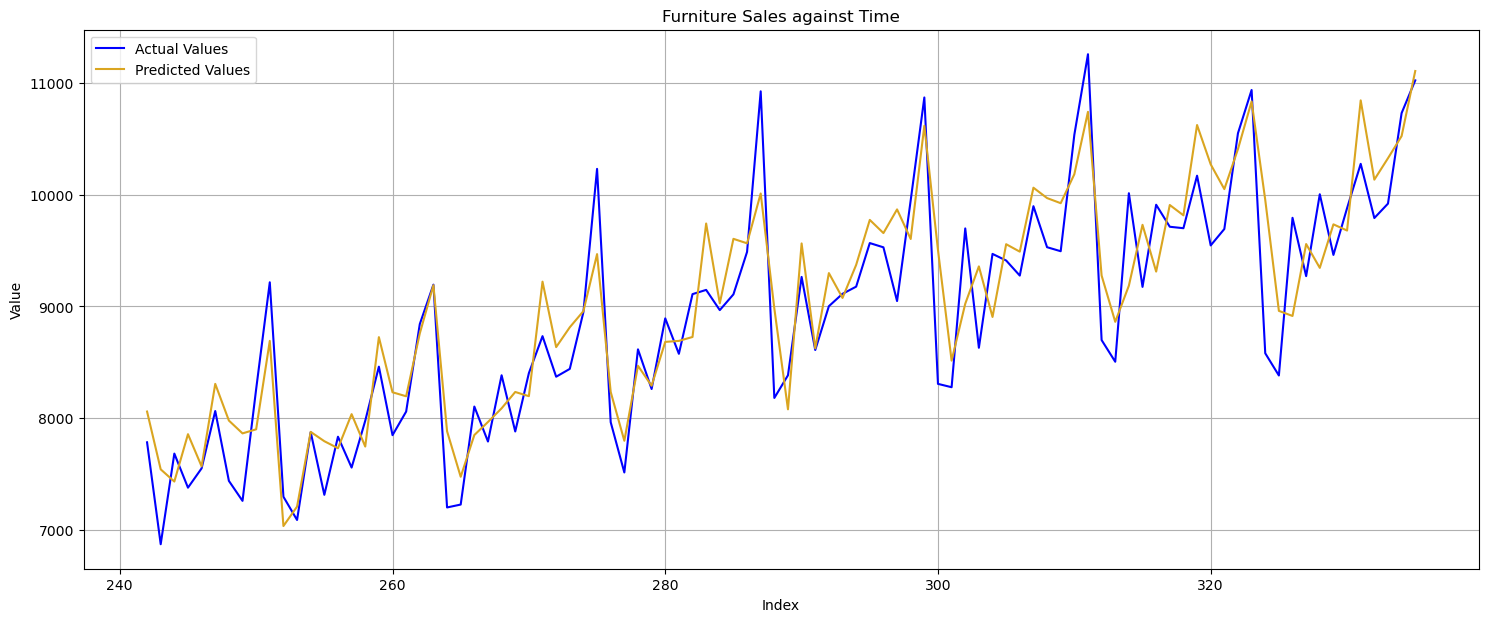

In [50]:
# print prediction results
print(df_test['preds'])

# plot time plot for predictions and ground truth 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Furniture Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_test['Sales'],
    color='blue', label='Actual Values');
ax.plot(
    df_test['preds'],
    color='goldenrod', label='Predicted Values')
ax.legend();